# Linear Regression
## The Solution Space
** November 2017 **

** Andrew Riberio @ [AndrewRib.com](http://www.andrewrib.com) **

In this notebook we will explore the solution space of linear regression with the mean squared error. 

** Note: ** This notebook contains interactive elements and certain latex snippets that will not render in github markdown. You must run this notebook on your local Jupyter notebook environment. 

## Libraries

In [9]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets as skd
from IPython.display import display
from sympy import MatrixSymbol, Matrix
from numpy.linalg import inv
from ipywidgets import interact, interactive, fixed, interact_manual
from mpl_toolkits.mplot3d import Axes3D

sp.init_printing(order='rev-lex',use_latex='mathjax')

## Linear Regression via Linear Least Squares

Let's begin with an interactive plot that will allow you to explore the relationship between:
* **The Regression Line**
    * Slope: The angle of the line. 
    * Y-Intercept: Where the line intercepts the y axis. 
    * Predicted Value = Slope * Dependent Variable + Y-Intercept
    
    
* **Dataset**
    * Generating function: Our dataset is synthetically generated by sampling a linear function, then adding noise. 
    * Noise: a certain ammount of noise will be added to each sampling of the generating function. 


* **Mean Squared Error**
    * How well our regression line fits the data. The smaller the value, the better the fit. See the definition of the calculation below. In machine learning terms, this is our cost function. 


In [11]:
def mse(yPredict,yActual):
    return np.square(yPredict.T-yActual.T).mean()
    
def h(slope,y_intercept):
    return lambda x:slope*x+y_intercept

def interactiveLine(slope,y_intercept,noise=50):
    X,Y = skd.make_regression(100,1,random_state=0, noise=noise)
    
    ys = np.apply_along_axis(h(slope,y_intercept), 0, X)
    
    plt.figure(figsize=(10,10))
    
    plt.title("Mean Squared Error: {0}".format(mse(ys,Y)),fontsize=15)
    plt.ylabel("Dependent Variable (Y)",fontsize=15)
    plt.xlabel("Independent Variable (X)",fontsize=15)
    plt.scatter(X,Y)
    plt.plot(X,ys)

    plt.show()
    

interact(interactiveLine, slope=(-150,150),y_intercept=(-100,100),noise=(0,150));

interactive(children=(IntSlider(value=0, description='slope', max=150, min=-150), IntSlider(value=0, description='y_intercept', min=-100), IntSlider(value=50, description='noise', max=150), Output()), _dom_classes=('widget-interact',))

### Plotting the solution space.
We will now enumerate all linear functions with all combinations of integer slopes and y-intercepts within [-150,150]. We therefore have:

* The X Axis:    150*2=300 unique slopes
* The Y Axis:    150*2=300 unique y-intercepts
* The X*Y Plane: 300^2 = 9,0000 unique linear regression lines. 

The $slope * yIntercept$ space creates a plane, the x and y axes, where each point represents a particular regression line. 

The z axis will represent the MSE for that regression line on the data:


$$
\large MSE(\mathbf{x},\mathbf{y},h_\theta) = \frac{1}{m} \sum_{i=1}^m{(h_\theta(x^i) - y^i})^2  \tag{1} \\ 
$$

Where:
* $\theta_0$ = y_intercept 
* $\theta_1$ = slope
* $h_\theta(\mathbf{x})= \mathbf{\theta_{0}}+ \mathbf{\theta_{1}}\mathbf{x}$

In this section we will use the following synthetic dataset.

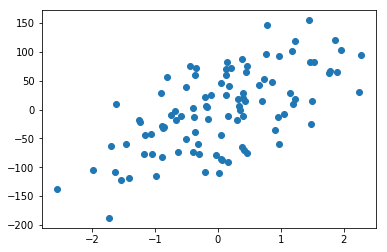

In [3]:
X,Y = skd.make_regression(100,1,random_state=0, noise=50)

plt.scatter(X,Y)
plt.show()

In [30]:
# This can be done much more efficiently with matrix algebra, but this is the clearest way of doing this. 
# Enumerate over the entire space of linear functions within the ranges. 
# This cell will take a while to compute. 

# Uses h(slope,yInter)
def enumFnsAndMSE(possibleSlopes,possibleYInter,X_Data,Y_Data,scaleFactor=1):
    errorOverLines = []

    for slope in possibleSlopes:
        row = []

        for yInter in possibleYInter:
            lFN = h(slope,yInter)
            regressionYs = np.apply_along_axis(lFN, 0, X_Data)
            row.append( mse(regressionYs,Y_Data)/scaleFactor )

        errorOverLines.append(row)
        
    return np.matrix(errorOverLines)

possibleSlopes = range(-150,150)
possibleYInter = range(-150,150)

errorOverLines = enumFnsAndMSE(possibleSlopes,possibleYInter,X,Y,600)

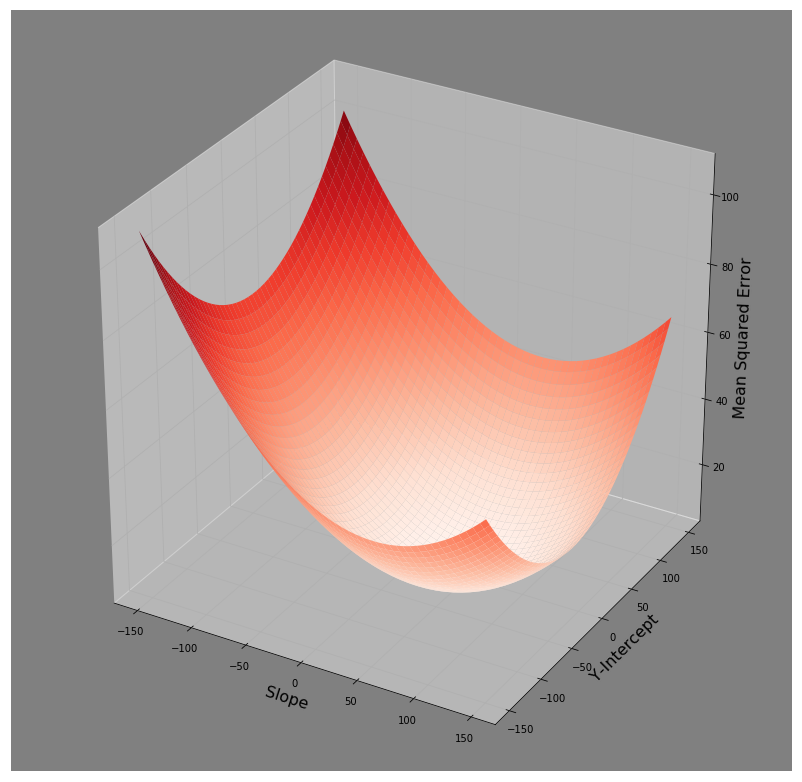

In [29]:
# Plot figure 
xx, yy = np.mgrid[-150:150, -150:150]

fig = plt.figure(figsize=(14,14))
ax = fig.gca(projection='3d',facecolor='gray')

ax.set_xlabel('Slope',fontSize=16)
ax.set_ylabel('Y-Intercept',fontSize=16)
ax.set_zlabel('Mean Squared Error',fontSize=16)

ax.plot_surface(xx, yy, errorOverLines, cmap=plt.cm.Reds, linewidth=0.2)
plt.show()

The plot you see above is characteristic of convex optimization problems. If we put a ball anywhere on this surface, it will roll down to the bottom AKA the global minimum. A ball with no force applied will follow the steepest path -- the path where the gradient is largest. If we did apply some sideways force, it will roll across the sides until it settles to the bottom -- it may jump out of the bottom a few times untill it loses all of its kenetic energy. This method of using [momentum is actually usefull in some non-convex optimization problems, because it forces us to explore a wider area](https://distill.pub/2017/momentum/).

I'd like to make something clear that wasn't made so clear to me when I was first learning about convex optimization. Why do we care about things like a ball rolling down the slopes? The figure you see above is a plot of all possible solutions within some precision ( i.e. we had integer ranges for our possible slopes and y-intercepts, we could have had more precise floating point ranges ). Because this is a toy problem on a toy dataset, enumerating all possible solutions doesn't take too much time. When we start working with real world data with millions of datapoints, and much higher dimensions (i.e. polynomial regression) enumerating the entire solution space becomes combinatorially explosive. Therefore, in the absense of a closed-form solution, we are concerned with starting at some point, some solution, and making it better until we arrive at a solution we can't make better. Focusing on making a solution better and better until we can't is computationally cheap, expecially in the case of convex optimizaiton. 

In order to formalize this notion of the motion of a ball rolling around this space of solutions, we must introduce the notion of the gradient. We will explore this in the gradient descent notebook. 

### Producing Optimal Linear Regression Lines
There are two primary optimization methods to produce a line that minimizes the MSE (as explored above): 
#### 1. Itterative Optimizaiton Methods
Itterative methods behave simmilarly to how you adjusted to the parameters above to get the best fitting line: we adjust the slope and bias so that it keeps getting smaller. Because linear regression is a convex optimization problem, we are always garenteed that if we follow this gradient, the value will always get smaller until it reaches it's minimum value -- which is garenteed to be a global minimum in the case of convex optimization. 

Examples:
    * Gradient Descent
    * Newton's Method
    * Exhaustive Search
#### 2. Closed-Form Methods
In some simpler optimization methods, as in linear least squares, we can actually derive the optimal solution analytically -- where we solve an equation and get the optimal result. 

Examples:
    * Normal Equations
    
** We will explore Gradient Descent and the Normal Equations in other notebooks. **

### Example - Exhaustive Search
When plotting the solition space above, we performed an exhaustive search within some precision -- being the intervals of the candidate slopes and y-intercepts. Let's use this and plot which line best fit our data in the exhaustive search. 

In [ ]:
def findMinimum(eol):
    rowLen = len(eol)
    colLen = len(eol[0])
    
    minVal = 100000000
    minCord = []
    
    for r_i in range(rowLen):
        for c_i in range(colLen):
            if(eol[r_i][c_i] < minVal):
                minVal = eol[r_i][c_i] 
                # We split the range in half to account for the negative values. 
                minCord = [r_i-rowLen/2,c_i-colLen/2]
                
    return [minCord,minVal]
            

bestLine = findMinimum(errorOverLines)
minSlope,minIntercept = findMinimum(errorOverLines)[0]
ys = np.apply_along_axis(h(minSlope,minIntercept), 0, X)

plt.scatter(X,Y)
plt.plot(X,ys)

plt.show()
print("MSE of line: {0}".format(bestLine[1]))